In [37]:
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from skimage import io, transform
import numpy as np
from torchvision import utils, transforms, datasets
from torch.utils.data import Subset
from datetime import datetime

In [38]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.

In [39]:
from dataset_transformations import *

In [40]:
torch.cuda.is_available()

True

In [41]:
class TrafficSignsDataset(Dataset):
    def __init__(self, annotations_file, root_dir, transform=None, target_transform=None):
        """
        Arguments:
            annotations_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.annotations_file = pd.read_csv(annotations_file)
        self.img_labels = self.annotations_file['ClassId']
        self.img_path = self.annotations_file['Path']
        self.img_width = self.annotations_file['Width']
        self.img_height = self.annotations_file['Height']
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.img_path.iloc[idx])
        image = io.imread(img_path)
        label = self.img_labels.iloc[idx]
        img_width = self.img_width.iloc[idx]
        img_height = self.img_height.iloc[idx]

        sample = {'image': image, 'label': label, 'img_width': img_width, 'img_height': img_height}
        
        if self.transform:
            sample = self.transform(sample)

        return sample
    
    def get_classes(self):
        return self.img_labels.unique()

In [42]:
training_data_transform = transforms.Compose([
        ConvertPIL(),
        Rescale((32, 32)),
        RandCrop(32),
        RandHorizFlip(0.5),
        RandVertFlip(0.5),
        # RandomRotation(),
        ToTensor()
        #transforms.Normalize(mean=[0.485, 0.456, 0.406],
        #                     std=[0.229, 0.224, 0.225])
    ])

validation_data_transform = transforms.Compose([
        ConvertPIL(),
        Rescale((32, 32)),
        # RandCrop(32),
        # RandHorizFlip(0.5),
        # RandVertFlip(0.5),
        # RandomRotation(),
        ToTensor()
        #transforms.Normalize(mean=[0.485, 0.456, 0.406],
        #                     std=[0.229, 0.224, 0.225])
    ])

In [43]:
train_dataset = TrafficSignsDataset(annotations_file='../../dataset/GTSRB/Train.csv', 
                                            root_dir='../../dataset/GTSRB',
                                            transform=training_data_transform)

valid_dataset = TrafficSignsDataset(annotations_file='../../dataset/GTSRB/Train.csv', 
                                  root_dir='../../dataset/GTSRB',
                                  transform=validation_data_transform)

total_count = len(train_dataset)
train_count = int(0.8 * total_count)
print(total_count)
print(train_count)
indices = np.arange(0, total_count, 1)
np.random.seed(42)
np.random.shuffle(indices)
train_idx, val_idx = indices[:train_count], indices[train_count:]

train_dataset = Subset(train_dataset, train_idx)
valid_dataset = Subset(valid_dataset, val_idx)

39209
31367


In [44]:
print(train_dataset.dataset.transform)
print(valid_dataset.dataset.transform)

Compose(
)
Compose(
)


In [45]:
train_dataset_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=64,
                                             shuffle=True,
                                             num_workers=4)

validation_dataset_loader = torch.utils.data.DataLoader(valid_dataset,
                                             batch_size=64,
                                             shuffle=True,
                                             num_workers=4)

In [46]:
def show_traffic_signs(sample_batched):
    """Show traffic signs for a batch of samples."""
    images_batch = sample_batched['image']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    plt.title('Batch from dataloader')

0 torch.Size([64, 3, 32, 32])
1 torch.Size([64, 3, 32, 32])
2 torch.Size([64, 3, 32, 32])
3 torch.Size([64, 3, 32, 32])
4 torch.Size([64, 3, 32, 32])


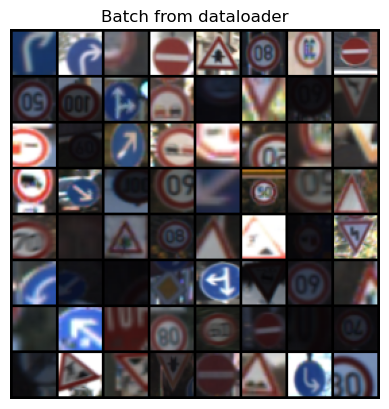

In [47]:
for i_batch, sample_batched in enumerate(train_dataset_loader):
    print(i_batch, sample_batched['image'].size())
    # observe 4th batch and stop.
    if i_batch == 4:
        plt.figure()
        show_traffic_signs(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

0 torch.Size([4, 3, 32, 32]) tensor([ 3, 11,  8, 10])
1 torch.Size([4, 3, 32, 32]) tensor([13, 21,  3, 13])
2 torch.Size([4, 3, 32, 32]) tensor([ 4,  8, 38, 35])
3 torch.Size([4, 3, 32, 32]) tensor([25,  4,  2, 38])
4 torch.Size([4, 3, 32, 32]) tensor([32, 25,  9,  2])


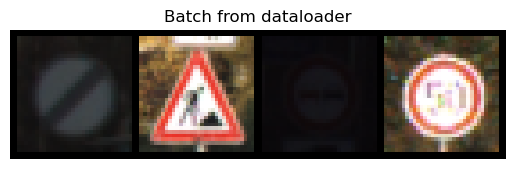

In [48]:
test_traffic_dataset = TrafficSignsDataset(annotations_file='../../dataset/GTSRB/Test.csv', 
                                           root_dir='../../dataset/GTSRB', transform=
                                           transforms.Compose([
                                            ConvertPIL(),
                                            Rescale((32, 32)),
                                            ToTensor()
                                        ]))

test_dataset_loader = torch.utils.data.DataLoader(test_traffic_dataset,
                                                batch_size=4,
                                                shuffle=True,
                                                num_workers=0)

for i_batch, sample_batched in enumerate(test_dataset_loader):
    print(i_batch, sample_batched['image'].size(), sample_batched['label'])
    # observe 4th batch and stop.
    if i_batch == 4:
        plt.figure()
        show_traffic_signs(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [49]:
import torch.nn as nn
import torch.nn.functional as F

num_classes = len(train_dataset.dataset.get_classes())
print(num_classes)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Height = (Input Height + Padding height (top and bottom) - Kernel Height) / Stride Height + 1
        # Width = (Input Width + Padding width (left and right) - Kernel Width) / Stride Width + 1
        
        # [BatchSize Channels Width Height]
        # Input [64 3 32 32]
        # Output [BatchSize NUM_KERNELS 32+0-3/1+1 32+0-3/1+1] = [64 32 30/1 30/1] = [64 32 30 30]
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3, 3), stride=1, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=0)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=1, padding=0)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=(3, 3), stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=(3, 3), stride=1, padding=0)
        self.fc1 = nn.Linear(256 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = self.pool(x)

        x = F.relu(self.conv4(x))
        x = self.pool(x)
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = self.dropout()
        x = F.relu(self.fc3(x))
        #x = self.fc3(x)
        return x


net = Net()

43


In [50]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net.to(device)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(3, 3), stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=43, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [51]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [52]:
EPOCHS = 5

In [53]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_dataset_loader):
        # Every data instance is an input + label pair
        inputs = data['image']
        labels = data['label']

        inputs, labels = inputs.to(device), labels.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = net(inputs)

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 100 # loss per batch
            print('batch {} loss: {}'.format(i + 1, last_loss))
            # tb_x = epoch_index * len(train_dataset_loader) + i + 1
            # tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [54]:
best_vloss = 1_000_000.
epoch_number = 0
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

for epoch in range(EPOCHS):  # loop over the dataset multiple times
    print('EPOCH {}:'.format(epoch_number + 1))
    running_loss = 0.
    last_loss = 0.

    net.train(True)
    avg_loss = train_one_epoch(epoch)

    running_vloss = 0.0

    # Set the model in evaluation mode
    net.eval()
    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for j, val_data in enumerate(validation_dataset_loader):
            inputs = val_data['image']
            labels = val_data['label']

            inputs, labels = inputs.to(device), labels.to(device)
            
            target = net(inputs)
            vloss = criterion(target, labels)
            running_vloss += vloss
    
        avg_vloss = running_vloss / (j + 1)
        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

        # Log the running loss averaged per batch
        # for both training and validation
        # writer.add_scalars('Training vs. Validation Loss',
        #                 { 'Training' : avg_loss, 'Validation' : avg_vloss },
        #                 epoch_number + 1)
        # writer.flush()

        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            model_path = 'model_{}_{}'.format(timestamp, epoch_number)
            torch.save(net.state_dict(), model_path)
        
        epoch_number += 1

EPOCH 1:
batch 100 loss: 3.6191674184799196
batch 200 loss: 3.5627884531021117
batch 300 loss: 3.491087872982025
batch 400 loss: 3.3385934925079344
LOSS train 3.3385934925079344 valid 3.0026535987854004
EPOCH 2:
batch 100 loss: 3.044032793045044
batch 200 loss: 2.9339342880249024
batch 300 loss: 2.873977179527283
batch 400 loss: 2.808892481327057
LOSS train 2.808892481327057 valid 2.566469669342041
EPOCH 3:
batch 100 loss: 2.7371551537513734
batch 200 loss: 2.700191810131073
batch 300 loss: 2.6348745322227476
batch 400 loss: 2.6304219579696655
LOSS train 2.6304219579696655 valid 2.222041130065918
EPOCH 4:
batch 100 loss: 2.5771222281455994
batch 200 loss: 2.5678565430641176
batch 300 loss: 2.510793181657791
batch 400 loss: 2.4748536944389343
LOSS train 2.4748536944389343 valid 2.07222318649292
EPOCH 5:
batch 100 loss: 2.4670399904251097
batch 200 loss: 2.429573975801468
batch 300 loss: 2.3842050552368166
batch 400 loss: 2.3505119848251343
LOSS train 2.3505119848251343 valid 1.934388756

In [55]:
# net = Net()
# net.load_state_dict(torch.load(PATH))

net.eval()
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i, test_data in enumerate(test_dataset_loader):
        inputs = test_data['image']
        labels = test_data['label']

        inputs, labels = inputs.to(device), labels.to(device)

        # calculate outputs by running images through the network
        outputs = net(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 47 %
